# 데이터 불러오기 및 라벨링

In [1]:
import os

# 데이터셋의 루트 디렉토리
dataset_directory = '/home/jeonk636/ear_classification/eardrumDs'

# 클래스 이름 및 라벨을 매핑하기 위한 딕셔너리 생성
# normal:0, abnormal: 1
label_map = {
    'Aom': 1,
    'Chornic': 1,
    'Earwax': 1,
    'Normal': 0,
    'OtitExterna': 1,
    'tympanoskleros': 1
}

# 이미지 파일 경로 및 라벨을 저장할 리스트
image_paths = []
image_labels = []

# 제외 폴더
exclude_folders = {'Earventulation', 'Foreign', 'PseduoMembran'}

# 각 폴더에 대해 이미지 파일 경로 및 해당 라벨을 리스트에 추가
for label_folder in os.listdir(dataset_directory):
    if label_folder in exclude_folders:  # 이 폴더는 건너뛴다.
        continue
    folder_path = os.path.join(dataset_directory, label_folder)
    
    for image_filename in os.listdir(folder_path):
        # 폴더 내 파일이 실제 파일인지 확인하고 '.ipynb_checkpoints' 폴더를 건너뛴다.
        full_path = os.path.join(folder_path, image_filename)
        if os.path.isfile(full_path) and '.ipynb_checkpoints' not in full_path:
            image_paths.append(full_path)
            image_labels.append(label_map[label_folder])

In [2]:
image_paths[0:5]

['/home/jeonk636/ear_classification/eardrumDs/Aom/aom_1.tiff',
 '/home/jeonk636/ear_classification/eardrumDs/Aom/aom_10.tiff',
 '/home/jeonk636/ear_classification/eardrumDs/Aom/aom_100.tiff',
 '/home/jeonk636/ear_classification/eardrumDs/Aom/aom_101.tiff',
 '/home/jeonk636/ear_classification/eardrumDs/Aom/aom_102.tiff']

In [3]:
print(image_labels[0:50])

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [4]:
# 라벨 0과 라벨 1의 개수를 계산.
label_0_count = image_labels.count(0)
label_1_count = image_labels.count(1)

(label_0_count, label_1_count)

(534, 391)

# Split the Dataset 6 : 2 : 2 

In [5]:
import numpy as np
from sklearn.model_selection import train_test_split

# 이미지 경로와 라벨을 Numpy 배열로 변환
image_paths = np.array(image_paths)
image_labels = np.array(image_labels)

# 전체 데이터를 훈련+검증 세트와 테스트 세트로 분할
x_train_all, x_test, y_train_all, y_test = train_test_split(
    image_paths, image_labels, stratify=image_labels, test_size=0.2, random_state=42)

# 훈련+검증 세트를 훈련 세트와 검증 세트로 분할
x_train, x_val, y_train, y_val = train_test_split(
    x_train_all, y_train_all, stratify=y_train_all, test_size=0.2, random_state=42)

In [6]:
# 결과 출력
print("Train set:", len(x_train))
print("Validation set:", len(x_val))
print("Test set:", len(x_test))

Train set: 592
Validation set: 148
Test set: 185


In [7]:
print("Normal in Train set:", np.count_nonzero(y_train == 0))
print("Abnormal in Train set:", np.count_nonzero(y_train == 1))

Normal in Train set: 342
Abnormal in Train set: 250


In [8]:
print("image_paths shape:",image_paths.shape)
print("image_labels shape:",image_labels.shape)

image_paths shape: (925,)
image_labels shape: (925,)


### 증강하지 않은 이미지에 대한 CNN모델 적용

In [10]:
from PIL import Image
import matplotlib.pyplot as plt
import cv2
import tensorflow as tf
import random

2024-05-02 05:17:03.111151: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-02 05:17:03.150066: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-02 05:17:03.150089: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-02 05:17:03.151346: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-02 05:17:03.158413: I tensorflow/core/platform/cpu_feature_guar

In [11]:
# 이미지 파일 열기
img = Image.open('/home/jeonk636/ear_classification/eardrumDs/Aom/aom_1.tiff')

# 이미지의 너비, 높이 얻기
image_width, image_height = img.size

# 이미지의 채널 수 얻기
num_channels = len(img.getbands())

print('Image Width: ', image_width)
print('Image Height: ', image_height)
print('Number of Channels: ', num_channels)

Image Width:  500
Image Height:  500
Number of Channels:  3


#### 참고문헌: https://www.tensorflow.org/tutorials/images/cnn?hl=ko  

In [13]:
from tensorflow.keras.preprocessing.image import img_to_array, load_img

def load_and_preprocess_image(path, target_size=(500, 500)):
    # 이미지를 RGB로 변환하여 로드
    image = Image.open(path).convert('RGB')
    image = image.resize(target_size)  # 목표 크기로 리사이징
    image = np.array(image)  # 이미지를 numpy 배열로 변환
    image = tf.convert_to_tensor(image, dtype=tf.float32) / 255.0  # 텐서로 변환하고 정규화
    return image


x_train = np.array([load_and_preprocess_image(path) for path in x_train])
x_val = np.array([load_and_preprocess_image(path) for path in x_val])
x_test = np.array([load_and_preprocess_image(path) for path in x_test])

# Define the model
model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3, 3), activation='relu', input_shape=(500, 500, 3)),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(2)
])

# Compile the model
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train, epochs=30, validation_data=(x_val, y_val))

# Evaluate the model
test_loss, test_acc = model.evaluate(x_test, y_test)
print('Test accuracy:', test_acc)

Epoch 1/30
19/19 [==============================] - 11s 502ms/step - loss: 3.1896 - accuracy: 0.6047 - val_loss: 0.6374 - val_accuracy: 0.6689
Epoch 2/30
19/19 [==============================] - 9s 470ms/step - loss: 0.6290 - accuracy: 0.6689 - val_loss: 0.6110 - val_accuracy: 0.6689
Epoch 3/30
19/19 [==============================] - 9s 487ms/step - loss: 0.5921 - accuracy: 0.6807 - val_loss: 0.5914 - val_accuracy: 0.7027
Epoch 4/30
19/19 [==============================] - 9s 460ms/step - loss: 0.5619 - accuracy: 0.7162 - val_loss: 0.6035 - val_accuracy: 0.6959
Epoch 5/30
19/19 [==============================] - 9s 497ms/step - loss: 0.5311 - accuracy: 0.7331 - val_loss: 0.5948 - val_accuracy: 0.7162
Epoch 6/30
19/19 [==============================] - 9s 462ms/step - loss: 0.5057 - accuracy: 0.7568 - val_loss: 0.5722 - val_accuracy: 0.7432
Epoch 7/30
19/19 [==============================] - 9s 465ms/step - loss: 0.4656 - accuracy: 0.7635 - val_loss: 0.5795 - val_accuracy: 0.7027
Epoch

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 498, 498, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2  (None, 249, 249, 32)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 247, 247, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 123, 123, 64)      0         
 g2D)                                                            
                                                                 
 flatten (Flatten)           (None, 968256)            0         
                                                                 
 dense (Dense)               (None, 64)                6

5/5 - 1s - loss: 1.4689 - accuracy: 0.7162 - 555ms/epoch - 111ms/step


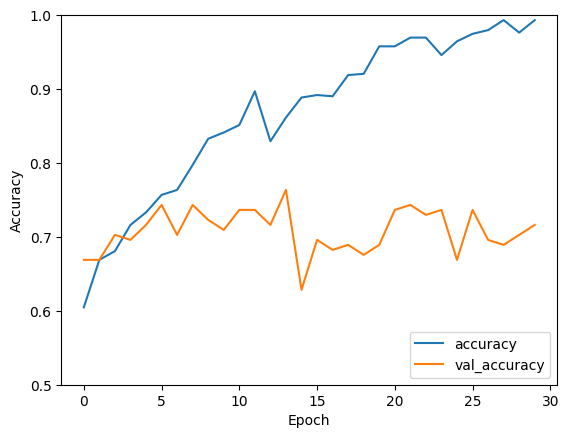

In [15]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(x_val,  y_val, verbose=2)